# Perceptrons & Neural Nets

The following notebook is a guided exploration of deep learning using the `torch` package. Before beginning this lab, be sure to install the `pip` packages listed in the python code-blocks by running the code-blocks themselves. This should install the required packages needed for you to complete this lab.

We will use a "reduced" version of the original 800 MB dataset. (only 30 MB).

Note: this might take a while to install (2-3 mins).

As this code is abstract, just follow along with the code-blocks and appreciate the computation.

Credit to [Shubham Shinde](https://www.kaggle.com/shindeshubham85) for the notebook.

Modifications to instructions and code are indicated via a note from me: (*Note*: ...)

In [19]:
!pip install keras
!pip install tensorflow
!pip install plotly
!pip install pydot


In [2]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import glob

2024-02-14 21:30:56.752554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# A Friendly ☺️ Introduction to CNNs with Keras

This is a basic introduction to anyone getting started with CNNs. This is practitioner's guide, so there's not a lot of theory.

**Computer Vision**

In a nutshell, CNNs are special deep learning architectures that have revolutionized the field of computer vision. Computer Vision is a field that is concerned about deriving information from images using computers. Some examples of computer vision include- Identifying whether a given image contains an item, like identifying a pedestrian in traffic, identifying cracks in an industrial machine, identifying if an X-Ray is abnormal. Self-Driving cars rely on computer vision algorithms, which are often CNNs. Filters on Instagram, face recognition systems, all use deep learning under the hood.

But some general types of computer vision problems are:

* Image Classification (Is this image of a cat?)
* Object Detection (Is there a cat in this image, and WHERE exactly is it?)
* Segmentation (give me the exact outline of the cat in this image, if it exists)

![image](https://github.com/The-Knowledge-House/DS_22/assets/26397102/8c2b25a3-0d81-4ba8-869b-0607305896e8)

**Difference from Traditional Modeling**

If you're here, it probably means you're familiar with basic machine learning concepts- like training data, predictions, feature engineering, etc. on tabular data. However image data is different from tabular data due to having a different structure, hence traditional algorithms like random forest cannot be used for classifying images.

**The CNN Breakthrough**

This is where CNNs made the breakthrough, and achieved tremendous results on image data. Before CNNs, image analytics required a lot of feature engineering and pre-processing (tons of hand-made filters). CNNs outperformed all the traditional methods without requiring such feature engineering. CNNs learnt the features and filters by itself. All you had to do was feed a lot of data to the model.

**Deep Learning and Neural Networks**

CNN, that is, Convolutional Neural Networks are a subfield of neural networks, a family of algorithms. A neural network is a collection of nodes or neurons, where each neuron has a weight*. These weights are learnt during the training process such that the model is able to predict the output when input is given. When a lot of such neurons are stacked together, we get a neural network. A neural network with a lot of layers would be called deep neural network, a phenomenon which has driven majority of the AI success in the last decade.

In CNNs, the neurons are arranged and stacked in a manner suitable for images.

**Convolutional Neural Networks**

In CNN, we have filters (which are tiny 3x3 matrices) which "convolve" an image to get a transformed matrix. We won't worry about the theory and filters here. All you need to know, that filters transform the image to a new matrix. This matrix is made smaller by a method called Pooling. These two operations create one Convolution Layer, and several such Layers create a CNN. This order isn't mandatory, as we'll see later.

This is a [nice animation](https://www.youtube.com/watch?v=YRhxdVk_sIs) that showcases the convolution operation.

**Transfer Learning**

There's a neat trick in deep learning called transfer learning- which is covered at the end of the notebook in case you make it.

That's quite a lot of theory, on to the problem at hand.

## Problem At Hand

The task at hand is an image classification task. You're given a ton of images that are either a cat image or a dog image. Now, if you give a new image, you should be able to predict if it's of a dog or a cat.

We are going to train a CNN to do this. Using the keras library.

### Typical Workflow
Typically when you work on a CNN task, this is how your notebook flow will look like: Whatever time you spend with CNNs, it will be in one of these sections.

**1 Get the Images**
(collecting images itself can be either a herculean task or sometimes ready-made data is available, time and effort varies with dataset)

Difficulty Level: Varies Time Needed: Varies

**2 Look at the Images and the Targets**
(see how the images actually look like, what are the classes, how many of them.)

**3 Create a Data Loader**
(in most libraries you need a guy that reads the images and feeds to the model, and does the intermediate work- batching, augmentation, split, multiprocessing, etc. configuring this step will be a good chunk of your time )

**4 Define Your Model**
(how many CNN layers? How many filters, the optimizer, the loss function? this could be as easy as downloading/pasting an existing model in ten minutes, or the experiments could go on forever)

**5 Train the Model**
(now throw the dataloader function on the model and let it train. sit back and sip coffee.)

**6 Get The Predictions**
(here you actually use the model. for some task, or just to check if it's doing good. evaluating whether the model is giving good predictions can also be challenging in some use cases.)

Debugging
If you keep it simple, load pre-built modules, the model will work. But there could be many possible problems that might arise in the task. These will be covered at the end.#

## 1. Get the Images

Extract the images from the zip file. 

In [3]:
import zipfile

with zipfile.ZipFile("cats_dogs_light.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("cats_dogs_light.zip","r") as z:
    z.extractall(".")


Now there are two folders: train/ and test1/

(feel free to look through them to appreciate the dogs & cats)

In [4]:
glob.glob("cats_dogs_light/train/*.jpg")[:5]

['cats_dogs_light/train/cat.10151.jpg',
 'cats_dogs_light/train/dog.1035.jpg',
 'cats_dogs_light/train/dog.1021.jpg',
 'cats_dogs_light/train/dog.10208.jpg',
 'cats_dogs_light/train/cat.10145.jpg']

In [5]:
train_files = glob.glob("cats_dogs_light/train/*.jpg")
train_labels = [i.strip('cats_dogs_light/train/')[:3] for i in train_files]
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
train_df.head()

,filename,class
0,cats_dogs_light/train/cat.10151.jpg,.10
1,cats_dogs_light/train/dog.1035.jpg,.10
2,cats_dogs_light/train/dog.1021.jpg,.10
3,cats_dogs_light/train/dog.10208.jpg,.10
4,cats_dogs_light/train/cat.10145.jpg,.10


## 2. Look at Them!

We now observe what the images look like. We'll look at four random images from the data.

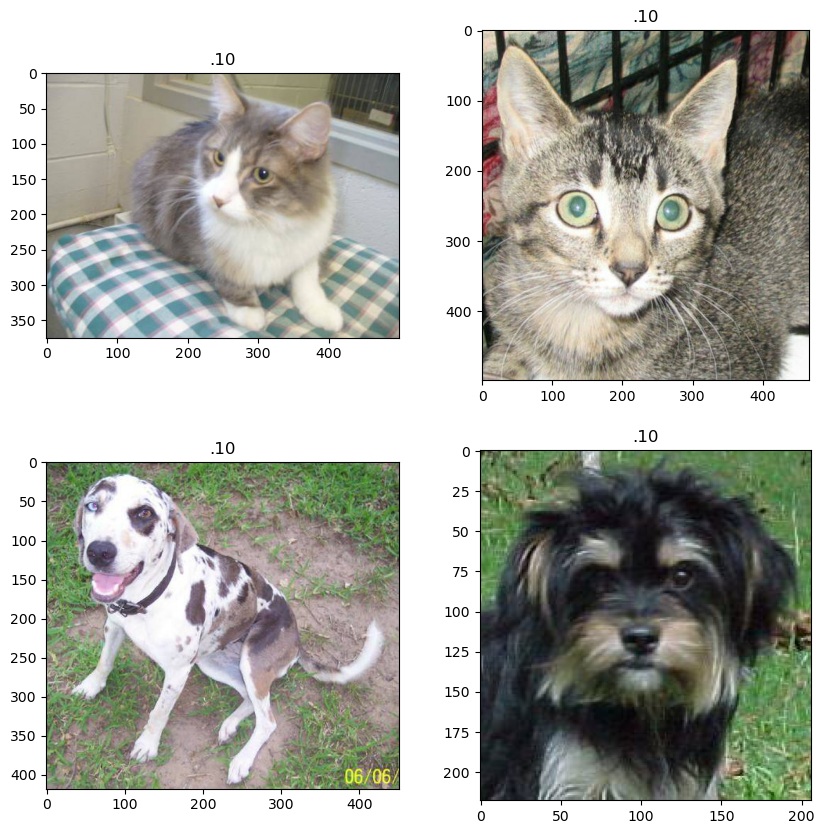

In [6]:
# observe your images!

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])

This is a pretty clean dataset- that's good. The subjects of the image are in center, occupy a majority of the image, no blurriness or anything. (Ideally you'd look at more images than a dozen tho,:) )

You might've noticed that the dimensions of the images are not constant, they vary a lot. This will be a problem for the CNN- it expects images of a fixed size! How do we take care of it? We don't, our data loader guy will do it for us.

(Well, sometimes we might want to do it ourselves, if we think the resizing needs extra attention- but in this case, we'll let it be automated.)

## 3. Release the Loader!
Dataloaders are the unsung heroes of the CNN world- they take care of a lot of nasty work that would be a nightmare if we had to do it by hand. What they essentially do is simple- read the data from the disk, and feed to the model. But under the hood they take care of many things, like...

1. Resizing, as we discussed. Ensuring that each image is of a fixed size.  
2. Batching. Feeding images one-by-one to the model is tedious, would take a lot of time. It's better to feed a large number of them at once (as much your computer will allow)  
3. Label Encoding. Computers don't understand string like 'cat' or 'dog', you have to convert them to numbers like 0 or 1.   
4. Data Augmentation. Create more images by slightly modifying an image (flipping it, rotating it teeny bit, adding some spots, etc.)  
5. Validation Split. Keras now has support for validation splitting.  
6. Sometimes the data is too large to fit into memory (10+ GB, say), then loaders can iterate through the dataset on disk chunk-by-chunk instead of loading everything at once.  

We are using keras's ImageDataGenerator to create our training data loader.

Two steps:

1. Define a ImageDataGenerator instance, and specify the augmentation strategies.  
2. Create a generator from this instance by specifying the image file paths and labels. Pass this generator to the model for training.  

In pytorch there's torch.utils.data.Dataset andtorch.utils.data.DataLoader. Sometimes you may need to define a custom dataloader, but the default is good enough for most use cases.

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# create a image data generator object. 
# all these are data augmentation parameters.

# now let's specify the image size to which each image will be resized to
img_height, img_width = 224, 224
batch_size = 64

There are two ways to create data generators/loaders from above instance. I recommend going through the ImageDataGenerator API page, but the two methods are:

Flow from Dataframe (here, you can contain the filenames and labels in a pandas dataframe, and pass the dataframe), we are using this, remember the dataframe we created earlier?  

Flow from Directory (here, you can pass the path of a directory. This directory should contain subfolders corresponding to each class. You will have to rearrange your directory so that it looks like this.

```
Train/
---| Dog/
   ---| Dog1.jpg
   ---| Dog1.jpg
---| Cat/
   ---| Cat1.jpg
   ---| Cat2.jpg
Val/
---| Dog/
   ---| Dog5.jpg
   ---| Dog6.jpg
---| Cat/
   ---| Cat7.jpg
   ---| Cat8.jpg
```

Since we are using method1, we will not be rearranging the folders.

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

# remember we put 0.2 validation split while defining ImageDataGenerator?
validation_generator = train_datagen.flow_from_dataframe(
    train_df, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

print("Class Indices:", train_generator.class_indices)

Found 800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.
Class Indices: {'.0.': 0, '.1.': 1, '.10': 2, '.99': 3}


## 4. Define A Model
Now we come to the meaty part- defining the CNN network, the engine of our application. As we discussed earlier, we are going to define a series of Convolution Layers, and each convolution layer consists of a convolution operation followed by a max pool layer.

This order is not mandatory- you can have two Convolution operations followed by one max pool, or three, or an average pool- that's the neat part of neural networks, they're so adaptable and malleable, and the best configurations are often found out by trial and error. In this case, we are going with the wisdom of our elders, and go by this order.

**Head of A CNN**  

As we apply more Conv Layers, you will get a transformed matrix of somesize x somesize. But what good is a matrix to us? We need a simple answer- 0 or 1! In order to get this answer, we "flatten" the final matrix to a single vector of size somesize-times-2 x 1. Then we pass it through more neural network neurons to get a single neuron at the end. This neuron's output is constrained between 0 and 1. This is our final probability! If it's greater than 0.5, the prediction is 1, if not, it's 0.

If you have more than 2 classes, like predicting a digit. In this case, there would be ten neurons at the end. Each of their output would be the probability of that class.

**Model Hyperparameters**  

Apart from number of Conv layers, there are other design choices while designing a CNN- they include selecting the optimizer, the learning rate, the loss function, the number of filters. For an introductory notebook, discussion on those is not necessary.

What's important to note: passing the input shape to the first layer. Ensuring that the last layer corresponds to the number of classes.

Try tinkering with this configuration to see how the results change. Try using only one Conv Layer, reducing number of filters, increasing number of filters, etc.

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(img_width, img_height, 3)))
# 32 here means this layer will contain 32 filters of size 3x3 being learnt
model.add(BatchNormalization())
# batchnorm is a useful layer that helps in convergence
model.add(MaxPooling2D(pool_size=(2, 2)))
# maxpooling will reduce the size of the image
model.add(Dropout(0.25))
# dropout is used for regularization, ensuring that model doesn't overfit

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# convolutional block is complete. now on to defining the "head"

# first flatten the matrix to get a single array
model.add(Flatten())
# adding a dense hidden layer of neurons
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# finally the output layer with neurons=number of classes and softmax activation
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

Let's visualize how our network looks like, and what the shapes of input and output at each layer.

The shapes of input and output can be useful for debugging. If there's a mismatch between output of one layer and input of next, model will throw up error.

In [26]:
from tensorflow.keras.utils import plot_model


In [31]:

# Assuming 'model' is your neural network model
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60, to_file='model_plot.png')


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [37]:
# compile the model while defining a loss, optimizer, and metrics to track, 
# and add callbacks if necessary
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [38]:
# this WILL take a while 


epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/10
13/13 [==============================] - 47s 3s/step - loss: 2.0735 - accuracy: 0.5713 - val_loss: 6.3948e-04 - val_accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 34s 3s/step - loss: 0.8410 - accuracy: 0.6488 - val_loss: 1.3013e-05 - val_accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 35s 3s/step - loss: 0.7546 - accuracy: 0.6425 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 38s 3s/step - loss: 0.6756 - accuracy: 0.7063 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 37s 3s/step - loss: 0.8414 - accuracy: 0.6888 - val_loss: 7.8431 - val_accuracy: 0.0000e+00
Epoch 6/10
13/13 [==============================] - 34s 3s/step - loss: 0.7373 - accuracy: 0.6750 - val_loss: 0.6049 - val_accuracy: 0.7200
Epoch 7/10
13/13 [==============================] - 34s 3s/step - loss: 0.6237 - accuracy: 0.7075 - val_loss: 6.6910e-04 - val_accuracy: 1.0

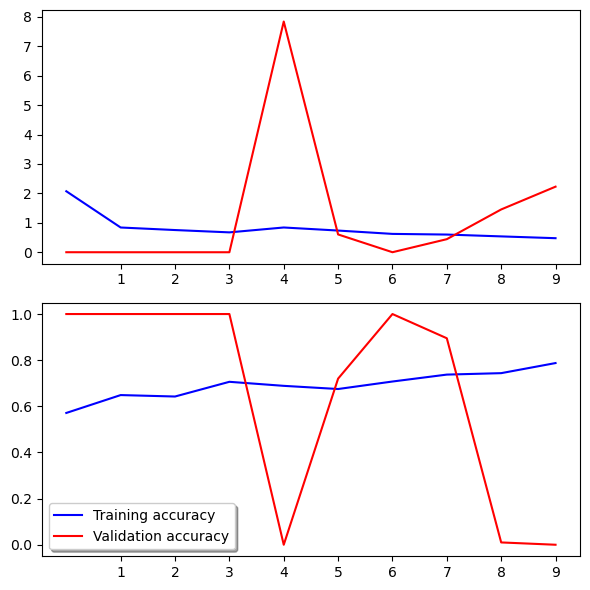

In [39]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()
plot_loss(history)

## 6. Get the Predictions
Now that the model is trained, let's check if the model is giving us good predictions, by trying it out on the test data.

In [43]:
test_files = glob.glob('cats_dogs_light/test/*.jpg')
test_df = pd.DataFrame({'filename': test_files})
test_df

,filename
0,cats_dogs_light/test\cat.9818.jpg
1,cats_dogs_light/test\cat.9819.jpg
2,cats_dogs_light/test\cat.9820.jpg
3,cats_dogs_light/test\cat.9821.jpg
4,cats_dogs_light/test\cat.9822.jpg
...,...
395,cats_dogs_light/test\dog.9954.jpg
396,cats_dogs_light/test\dog.9955.jpg
397,cats_dogs_light/test\dog.9956.jpg
398,cats_dogs_light/test\dog.9957.jpg


In [44]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False)

Found 400 validated image filenames.


2/2 [==============================] - 0s 200ms/step


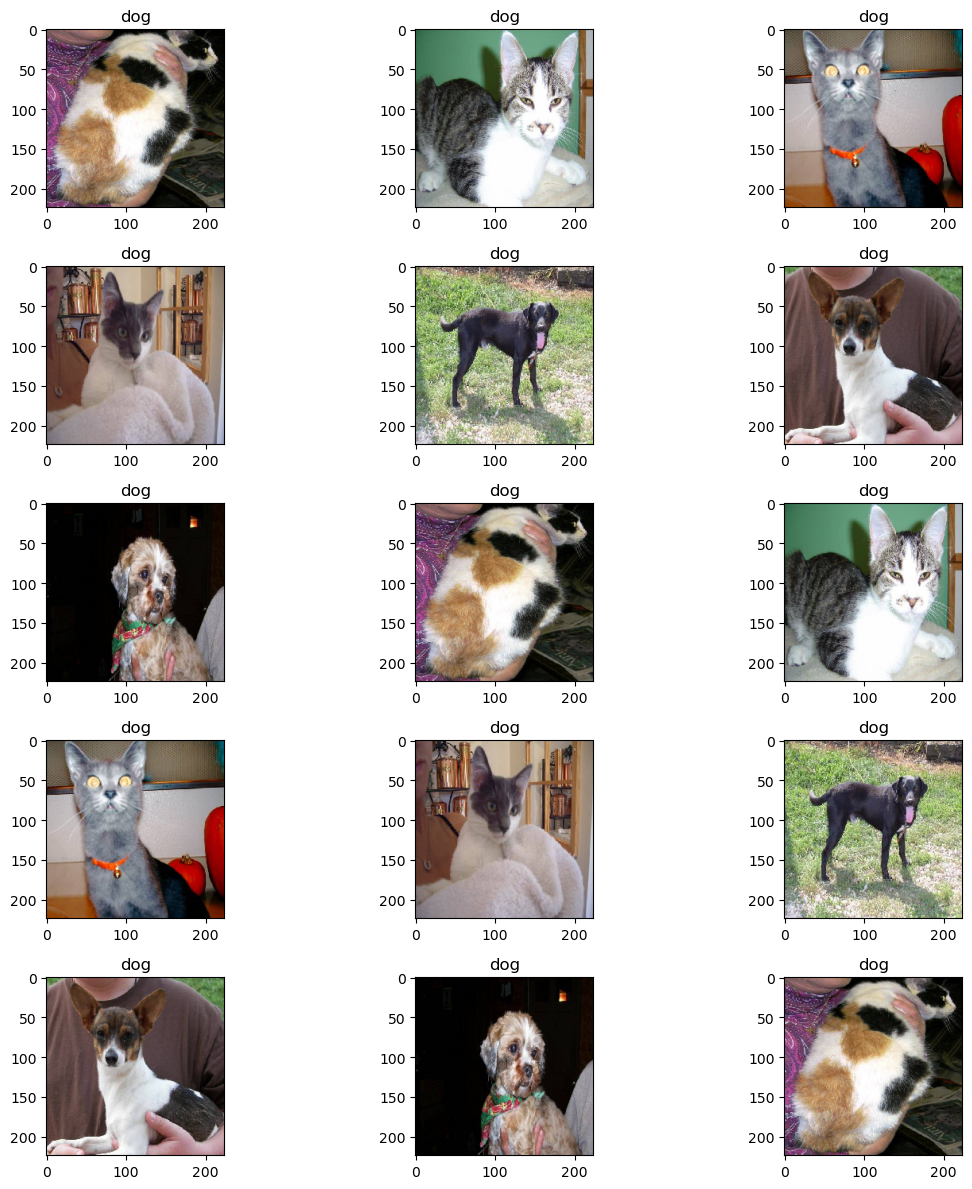

In [45]:
def visualize_predictions(test_generator, model):
    plt.figure(figsize=(12, 12))
    for i in range(0, 15):
        plt.subplot(5, 3, i+1)
        for X_batch in test_generator:
            prediction = model.predict(X_batch)[0]
            image = X_batch[0]
            plt.imshow(image)
            plt.title('cat' if np.argmax(prediction)==0 else "dog")
            break
    plt.tight_layout()
    plt.show()
visualize_predictions(test_generator, model)

##  Transfer Learning

If you made it here, we'll talk about deep learning's most important tricks- transfer learning!

Neural networks are notoriously data hungry- they can eat millions of images and digest them to be able to generalize upon their features. In this case, what if you don't have millions of images?

In this case, you use a model that has been trained on millions of images. And take it as your starting point. And train your model from them. Those massive datasets don't necessarily have to be related to your image classes.

There are many publicly available models like resnet, xception, convnext (particular architectures of CNNs) trained on ImageNet dataset (a very large image dataset with 100+ different classes). You can simply download them, and use it for your task (classifying dogs), and it will work much better than defining a model from new.

We'll implement a model using transfer learning below.

In [47]:
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import Input
from tensorflow.keras.models import Model

# ResNet50 is our "backbone" of sorts, a CNN architecture 
# pretrained on the imagenet dataset
# we are only taking the CNN portion of it (include_top = False)
# and dropping the dense layer, we'll initialize a dense network of our own

basemodel = Xception(include_top = False, 
                   weights = 'imagenet',
                  input_shape=(img_height, img_width, 3))

basemodel.trainable = False

# use the output of the baseModel to create a "head"
headModel = basemodel.output
headModel = MaxPooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.8)(headModel)
# headModel = Dense(32, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# at the end, we'll have two neurons, for two of the classes

# we're "disabling" the backbone, and only training the head for this task
# we're assuming that the backbone is already sufficiently trained to generate
# features from images like ours.
# we can also "disable" all CNN layers except last 4

# create a model object
model = Model(inputs=basemodel.input, outputs=headModel)

83683744/83683744 [==============================] - 10s 0us/step


## Experiment Tracking

In earlier case, we plotted our losses and metrics after the training was done, manually using matplotlib. But there are tools available using which we can observe real-time how our training is progressing. They also log system metrics like GPU usage, and can keep track of multiple experiments, hyperparameters etc. One such tool is wandb.ai, using which you can track your model even on phone as it's running in background.

Using it is very simple, signup on wandb.ai, and add only few lines of code. Get the API token, and go through this discussion on how to add it as a kaggle secret.

(we'll skip this step)

In [14]:
visualize_predictions(test_generator, model)

NameError: name 'visualize_predictions' is not defined

In [52]:
# finally, save your model! 

model.save("cats_and_dogs.h5")

c:\Users\saidmf\anaconda3\envs\phase1\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
